In [1]:
import numpy as np
import cv2 as cv
import os
import splitfolders
import matplotlib.pyplot as plt

import tensorflow.keras as keras
import tensorflow as tf

from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img

from tensorflow.keras import layers
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input

C:\Users\Admin\anaconda3\Lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [2]:
datagen = ImageDataGenerator()

In [3]:
class_names = ['cheeta','elephant','lion','neutral','tiger']

In [4]:
train_generator = datagen.flow_from_directory( 
    directory="dataset/training/", 
    classes = class_names,
    target_size=(224, 224),  
    batch_size=32, 
    class_mode="categorical", 
)

Found 1571 images belonging to 5 classes.


In [5]:
valid_generator = datagen.flow_from_directory( 
    directory="dataset/testing/", 
    classes = class_names,
    target_size=(224, 224), 
    batch_size=32, 
    class_mode="categorical", 
)

Found 349 images belonging to 5 classes.


In [6]:
test_generator = datagen.flow_from_directory( 
    directory="dataset/testing/", 
    classes = class_names,
    target_size=(224, 224), 
    batch_size=32, 
    class_mode="categorical", 
)

Found 349 images belonging to 5 classes.


In [7]:
resnet_50 = ResNet50(include_top=False, weights='imagenet', input_shape=(224,224,3))
for layer in resnet_50.layers:
    layer.trainable = False

In [8]:
x = resnet_50.output
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(512, activation='relu')(x) 
x = layers.Dropout(0.5)(x)
x = layers.Dense(256, activation='relu')(x) 
x = layers.Dropout(0.5)(x)
x = layers.Dense(128, activation='relu')(x) 
x = layers.Dropout(0.5)(x)
x = layers.Dense(64, activation='relu')(x) 
x = layers.Dropout(0.5)(x)
predictions = layers.Dense(5, activation='softmax')(x)
model = Model(inputs = resnet_50.input, outputs = predictions)

In [9]:
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint

def trainModel(model, epochs, optimizer):
    batch_size = 32
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    checkpoint = ModelCheckpoint(
            "model_weights.keras",  
            monitor='val_accuracy',
            verbose=1,
            save_best_only=True,
            mode='max'
        )
    callbacks_list = [checkpoint]
    return model.fit(train_generator, validation_data=valid_generator, epochs=epochs, batch_size=batch_size, callbacks=callbacks_list)

In [10]:
from PIL import Image
import os

def verify_images(directory):
    for filename in os.listdir(directory):
        try:
            img = Image.open(os.path.join(directory, filename))
            img.verify()  # Verify that it's an image
        except (IOError, SyntaxError) as e:
            print(f"Corrupted image: {filename}")

verify_images("C:/Users/Admin/Documents/animal detection/dataset/training/cheeta/")


In [11]:
model_history = trainModel(model = model, epochs = 5, optimizer = "Adam")


Epoch 1/5


 5/50 [==>...........................] - ETA: 2:36 - loss: 1.0550 - accuracy: 0.1813

C:\Users\Admin\anaconda3\Lib\site-packages\PIL\Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


50/50 [==============================] - ETA: 0s - loss: 0.6343 - accuracy: 0.2877
Epoch 1: val_accuracy improved from -inf to 0.89971, saving model to model_weights.keras
50/50 [==============================] - 225s 4s/step - loss: 0.6343 - accuracy: 0.2877 - val_loss: 0.4272 - val_accuracy: 0.8997
Epoch 2/5
50/50 [==============================] - ETA: 0s - loss: 0.3908 - accuracy: 0.5519
Epoch 2: val_accuracy did not improve from 0.89971
50/50 [==============================] - 209s 4s/step - loss: 0.3908 - accuracy: 0.5519 - val_loss: 0.2110 - val_accuracy: 0.8911
Epoch 3/5
50/50 [==============================] - ETA: 0s - loss: 0.2338 - accuracy: 0.7753
Epoch 3: val_accuracy improved from 0.89971 to 0.98281, saving model to model_weights.keras
50/50 [==============================] - 213s 4s/step - loss: 0.2338 - accuracy: 0.7753 - val_loss: 0.0691 - val_accuracy: 0.9828
Epoch 4/5
50/50 [==============================] - ETA: 0s - loss: 0.1311 - accuracy: 0.9083
Epoch 4: val_acc

In [12]:
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)

model.save("model2.h5")

C:\Users\Admin\AppData\Roaming\Python\Python311\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


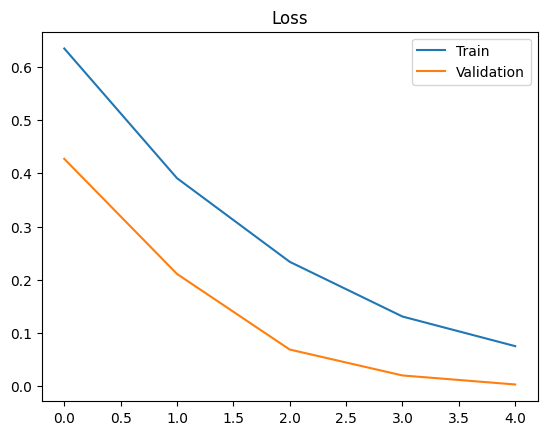

In [13]:
loss_train_curve = model_history.history["loss"]
loss_val_curve = model_history.history["val_loss"]
plt.plot(loss_train_curve, label = "Train")
plt.plot(loss_val_curve, label = "Validation")
plt.legend(loc = 'upper right')
plt.title("Loss")
plt.show()

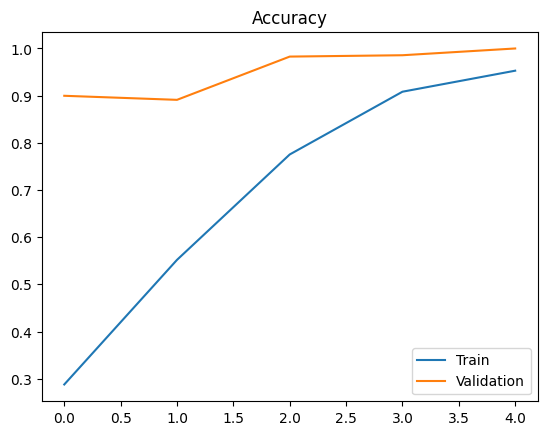

In [14]:
acc_train_curve = model_history.history["accuracy"]
acc_val_curve = model_history.history["val_accuracy"]
plt.plot(acc_train_curve, label = "Train")
plt.plot(acc_val_curve, label = "Validation")
plt.legend(loc = 'lower right')
plt.title("Accuracy")
plt.show()

In [15]:
test_loss, test_acc = model.evaluate(test_generator)
print("The test loss is: ", test_loss)
print("The best accuracy is: ", test_acc*100)

11/11 [==============================] - 38s 3s/step - loss: 0.0035 - accuracy: 1.0000
The test loss is:  0.0034607225097715855
The best accuracy is:  100.0


In [1]:
from tensorflow.keras.models import model_from_json
import numpy as np

class DetectionModel(object):

    class_nums = ["cheeta", "elephant", "lion","neutral","tiger"]

    def __init__(self, model_json_file, model_weights_file):
        with open(model_json_file, "r") as json_file:
            loaded_model_json = json_file.read()
            self.loaded_model = model_from_json(loaded_model_json)

        self.loaded_model.load_weights(model_weights_file)
        self.loaded_model.make_predict_function()

    def predict(self, img):
        self.preds = self.loaded_model.predict(img)
        return DetectionModel.class_nums[np.argmax(self.preds)], self.preds


C:\Users\Admin\anaconda3\Lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [2]:
import tensorflow as tf 
from tensorflow.keras.models import load_model
import numpy as np
from keras.preprocessing import image
import cv2
import numpy as np
import os

model = DetectionModel("model.json", 'model_weights.keras')
font = cv2.FONT_HERSHEY_SIMPLEX


def startapplication():
    video = cv2.VideoCapture(0) 
    while True:
        ret, frame = video.read()
        if not ret or frame is None:
            print("Error: Unable to read frame from the camera.")
            break
        gray_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        roi = cv2.resize(gray_frame, (224, 224))

        pred, prob = model.predict(roi[np.newaxis, :, :])
        print(prob)
        prob = (round(prob[0][0]*100, 2))         
            

        cv2.rectangle(frame, (0, 0), (280, 40), (0,0, 0), -1)
        cv2.putText(frame, pred+" "+str(prob), (20, 30), font, 1, (255, 255, 0), 2)

        if cv2.waitKey(33) & 0xFF == ord('q'):
            return
        cv2.imshow('Video', frame)  


if __name__ == '__main__':
    startapplication()





1/1 [==============================] - 2s 2s/step
[[1.2283245e-08 8.8312518e-10 4.7440024e-10 1.0000000e+00 2.4232165e-08]]
1/1 [==============================] - 0s 236ms/step
[[2.0466036e-08 1.5301432e-09 8.4204765e-10 1.0000000e+00 3.6187796e-08]]
1/1 [==============================] - 0s 195ms/step
[[5.7980483e-09 3.3519157e-10 1.8150863e-10 1.0000000e+00 1.1002548e-08]]
1/1 [==============================] - 0s 200ms/step
[[8.8719148e-09 4.9403920e-10 2.7399430e-10 1.0000000e+00 1.5968022e-08]]
1/1 [==============================] - 0s 193ms/step
[[2.1381917e-08 1.6191892e-09 9.2179342e-10 9.9999988e-01 3.7488512e-08]]
1/1 [==============================] - 0s 196ms/step
[[1.6903400e-08 1.1561616e-09 6.7026679e-10 1.0000000e+00 2.9332279e-08]]
1/1 [==============================] - 0s 197ms/step
[[2.6181731e-08 1.9720900e-09 1.1318072e-09 9.9999988e-01 4.5185786e-08]]
1/1 [==============================] - 0s 200ms/step
[[2.3613961e-08 1.6520951e-09 9.9345465e-10 9.9999988e-01 4

1/1 [==============================] - 0s 191ms/step
[[6.7689456e-08 4.1076156e-09 2.9235949e-09 9.9999976e-01 1.2294095e-07]]
1/1 [==============================] - 0s 192ms/step
[[1.9607244e-08 8.9465563e-10 5.8083838e-10 1.0000000e+00 3.8377021e-08]]
1/1 [==============================] - 0s 191ms/step
[[4.6318145e-09 1.4900997e-10 8.9100706e-11 1.0000000e+00 1.0438030e-08]]
1/1 [==============================] - 0s 190ms/step
[[8.1201108e-09 2.9191699e-10 1.7217570e-10 1.0000000e+00 1.9107176e-08]]
1/1 [==============================] - 0s 189ms/step
[[1.0477160e-06 7.7510002e-08 6.2133189e-08 9.9999714e-01 1.5929215e-06]]
1/1 [==============================] - 0s 194ms/step
[[4.9758518e-07 3.6417216e-08 2.7978770e-08 9.9999869e-01 7.8205056e-07]]
1/1 [==============================] - 0s 191ms/step
[[2.9715588e-08 1.4171986e-09 9.2210295e-10 9.9999988e-01 5.7161710e-08]]
1/1 [==============================] - 0s 190ms/step
[[1.24604815e-08 4.94041086e-10 3.10166115e-10 1.00000000e

1/1 [==============================] - 0s 207ms/step
[[3.5259924e-05 1.1690641e-05 8.6621858e-06 9.9989688e-01 4.7535446e-05]]
1/1 [==============================] - 0s 190ms/step
[[2.3188855e-04 2.7252518e-04 1.4915735e-04 9.9905390e-01 2.9253360e-04]]
1/1 [==============================] - 0s 199ms/step
[[3.7457919e-08 2.3233888e-09 1.6821304e-09 9.9999988e-01 5.9232910e-08]]
1/1 [==============================] - 0s 195ms/step
[[5.7276550e-10 1.7796117e-11 1.0445190e-11 1.0000000e+00 1.2566784e-09]]
1/1 [==============================] - 0s 200ms/step
[[3.6032191e-11 8.6887442e-13 4.4260792e-13 1.0000000e+00 9.5017223e-11]]
1/1 [==============================] - 0s 191ms/step
[[5.6057468e-11 1.3947075e-12 7.3349183e-13 1.0000000e+00 1.3877287e-10]]
1/1 [==============================] - 0s 202ms/step
[[9.2087005e-11 2.5362924e-12 1.3627994e-12 1.0000000e+00 2.1444946e-10]]
1/1 [==============================] - 0s 196ms/step
[[6.7015518e-11 1.6141932e-12 8.4791045e-13 1.0000000e+00 

1/1 [==============================] - 0s 196ms/step
[[0.02563227 0.00685526 0.00607261 0.22371009 0.7377298 ]]
1/1 [==============================] - 0s 188ms/step
[[5.7900047e-07 6.2080545e-08 3.6627789e-08 9.9999833e-01 8.7705172e-07]]
1/1 [==============================] - 0s 187ms/step
[[4.1727120e-08 2.5786877e-09 1.6014303e-09 9.9999988e-01 7.1984047e-08]]
1/1 [==============================] - 0s 198ms/step
[[6.3031692e-08 4.9473270e-09 2.8144160e-09 9.9999976e-01 1.3830929e-07]]
1/1 [==============================] - 0s 198ms/step
[[5.6394187e-09 4.3129594e-10 1.8407709e-10 1.0000000e+00 1.1399649e-08]]
1/1 [==============================] - 0s 193ms/step
[[2.2679027e-08 2.2831834e-09 1.0802952e-09 9.9999988e-01 4.1151409e-08]]
1/1 [==============================] - 0s 188ms/step
[[4.1780158e-08 4.2878638e-09 2.1543192e-09 9.9999988e-01 7.8374832e-08]]
1/1 [==============================] - 0s 199ms/step
[[8.85847484e-08 1.06141735e-08 5.31656985e-09 9.99999762e-01
  1.6371886

1/1 [==============================] - 0s 187ms/step
[[6.9308182e-05 1.4421646e-05 1.3498409e-05 9.9982041e-01 8.2429629e-05]]
1/1 [==============================] - 0s 187ms/step
[[1.3763759e-05 1.7810557e-06 1.6063896e-06 9.9996603e-01 1.6860269e-05]]
1/1 [==============================] - 0s 189ms/step
[[4.8447596e-08 3.1795062e-09 2.0443811e-09 9.9999988e-01 8.4173287e-08]]
1/1 [==============================] - 0s 186ms/step
[[3.6684059e-10 9.8279553e-12 5.4251941e-12 1.0000000e+00 8.2054841e-10]]
1/1 [==============================] - 0s 187ms/step
[[8.2409308e-08 8.5536245e-09 5.9929461e-09 9.9999976e-01 1.5593496e-07]]
1/1 [==============================] - 0s 191ms/step
[[6.0053694e-06 1.0268759e-06 6.9634882e-07 9.9998343e-01 8.8326087e-06]]
1/1 [==============================] - 0s 188ms/step
[[1.3204529e-09 6.0373734e-11 3.2092589e-11 1.0000000e+00 2.9719700e-09]]
1/1 [==============================] - 0s 188ms/step
[[2.7138456e-09 1.6278282e-10 7.9936759e-11 1.0000000e+00 

1/1 [==============================] - 0s 189ms/step
[[1.6455487e-06 2.1616449e-07 1.2511089e-07 9.9999523e-01 2.7314331e-06]]
1/1 [==============================] - 0s 185ms/step
[[2.1448177e-05 5.8691976e-06 3.3961455e-06 9.9994028e-01 2.9067454e-05]]
1/1 [==============================] - 0s 194ms/step
[[1.7690003e-05 3.8875869e-06 2.2761403e-06 9.9995208e-01 2.3991055e-05]]
1/1 [==============================] - 0s 193ms/step
[[4.4954615e-07 4.7871417e-08 2.4204557e-08 9.9999869e-01 7.8895283e-07]]
1/1 [==============================] - 0s 185ms/step
[[1.6424675e-06 2.0919673e-07 1.2054629e-07 9.9999511e-01 2.8295051e-06]]
1/1 [==============================] - 0s 197ms/step
[[4.1194994e-08 2.6712614e-09 1.4399089e-09 9.9999988e-01 8.0885087e-08]]
1/1 [==============================] - 0s 186ms/step
[[4.40137748e-09 2.09353909e-10 1.01140096e-10 1.00000000e+00
  8.75571793e-09]]
1/1 [==============================] - 0s 187ms/step
[[2.2358223e-07 2.1935232e-08 1.3060360e-08 9.99999

1/1 [==============================] - 0s 188ms/step
[[1.3795958e-09 8.1322671e-11 3.3386675e-11 1.0000000e+00 2.7663740e-09]]
1/1 [==============================] - 0s 193ms/step
[[5.9974528e-09 5.1794224e-10 2.2559792e-10 1.0000000e+00 1.1259708e-08]]
1/1 [==============================] - 0s 190ms/step
[[2.5403759e-08 3.1586889e-09 1.3208029e-09 9.9999988e-01 4.0505149e-08]]
1/1 [==============================] - 0s 189ms/step
[[8.3737017e-09 7.3614403e-10 3.0458902e-10 1.0000000e+00 1.4190042e-08]]
1/1 [==============================] - 0s 203ms/step
[[1.9912647e-09 1.4018790e-10 5.5698616e-11 1.0000000e+00 3.8543426e-09]]
1/1 [==============================] - 0s 198ms/step
[[1.2033540e-08 1.1247143e-09 4.8624815e-10 1.0000000e+00 2.0567583e-08]]
1/1 [==============================] - 0s 188ms/step
[[9.7481125e-09 9.2791114e-10 3.9151327e-10 1.0000000e+00 1.6834225e-08]]
1/1 [==============================] - 0s 191ms/step
[[9.2414281e-09 8.3888962e-10 3.5386816e-10 1.0000000e+00 

1/1 [==============================] - 0s 198ms/step
[[1.10191884e-07 7.94045363e-09 4.56293581e-09 9.99999762e-01
  1.74943011e-07]]
1/1 [==============================] - 0s 190ms/step
[[2.3048033e-06 3.2212557e-07 1.8291099e-07 9.9999404e-01 3.1106713e-06]]
1/1 [==============================] - 0s 187ms/step
[[3.5985822e-06 5.0741556e-07 2.9171775e-07 9.9999106e-01 4.5361157e-06]]
1/1 [==============================] - 0s 188ms/step
[[2.2146305e-06 2.7198135e-07 1.4737861e-07 9.9999464e-01 2.7537969e-06]]
1/1 [==============================] - 0s 185ms/step
[[1.4731766e-07 1.1368031e-08 6.5784986e-09 9.9999964e-01 2.1294039e-07]]
1/1 [==============================] - 0s 189ms/step
[[2.6632053e-08 1.3643996e-09 7.4581358e-10 9.9999988e-01 4.5092630e-08]]
1/1 [==============================] - 0s 195ms/step
[[5.2019232e-08 3.0547282e-09 1.8112628e-09 9.9999988e-01 8.3547405e-08]]
1/1 [==============================] - 0s 195ms/step
[[3.9525796e-07 3.2649048e-08 1.8960236e-08 9.99999

1/1 [==============================] - 0s 190ms/step
[[1.3919342e-03 1.4794372e-03 9.9207473e-01 4.3144352e-03 7.3943043e-04]]
1/1 [==============================] - 0s 196ms/step
[[0.00558344 0.00575118 0.9715304  0.01409901 0.00303597]]
1/1 [==============================] - 0s 191ms/step
[[0.01433244 0.01180841 0.92463565 0.04197839 0.00724517]]
1/1 [==============================] - 0s 194ms/step
[[0.01199996 0.01026871 0.9374764  0.03403274 0.00622213]]
1/1 [==============================] - 0s 190ms/step
[[0.01078073 0.01031452 0.9416446  0.03111554 0.00614458]]
1/1 [==============================] - 0s 192ms/step
[[0.01795538 0.01741674 0.7947626  0.16001698 0.00984827]]
1/1 [==============================] - 0s 201ms/step
[[0.04370641 0.02319845 0.4343467  0.4752633  0.02348523]]
1/1 [==============================] - 0s 196ms/step
[[0.03756997 0.02288982 0.34102094 0.5748778  0.02364145]]
1/1 [==============================] - 0s 193ms/step
[[1.3036903e-03 1.0142620e-03 9.9382

1/1 [==============================] - 0s 193ms/step
[[3.0597157e-04 2.7479868e-05 3.4863588e-05 9.9941051e-01 2.2114834e-04]]
1/1 [==============================] - 0s 188ms/step
[[7.740387e-05 5.929669e-06 6.885171e-06 9.998424e-01 6.733396e-05]]
1/1 [==============================] - 0s 188ms/step
[[1.8522969e-03 2.4247845e-04 3.2168641e-04 9.9628431e-01 1.2992752e-03]]
1/1 [==============================] - 0s 196ms/step
[[5.2056205e-04 3.9684805e-05 4.8949514e-05 9.9909985e-01 2.9094444e-04]]
1/1 [==============================] - 0s 190ms/step
[[3.3738583e-03 4.1255634e-04 5.6205719e-04 9.9371970e-01 1.9317394e-03]]
1/1 [==============================] - 0s 200ms/step
[[5.0963351e-04 3.6646554e-05 4.5369328e-05 9.9914670e-01 2.6158587e-04]]
1/1 [==============================] - 0s 201ms/step
[[5.0659501e-04 3.2152715e-05 4.0838182e-05 9.9918538e-01 2.3499910e-04]]
1/1 [==============================] - 0s 211ms/step
[[6.7867888e-03 4.5602885e-04 6.0857338e-04 9.9018610e-01 1.962

1/1 [==============================] - 0s 191ms/step
[[1.31210999e-03 1.05157043e-04 1.19624245e-04 9.97861326e-01
  6.01831824e-04]]
1/1 [==============================] - 0s 190ms/step
[[0.02604614 0.00226008 0.00249932 0.96172416 0.00747022]]
1/1 [==============================] - 0s 189ms/step
[[0.8713757  0.03099717 0.03392687 0.04471012 0.01899023]]
1/1 [==============================] - 0s 195ms/step
[[0.95451856 0.01203865 0.01409776 0.01364174 0.00570331]]
1/1 [==============================] - 0s 192ms/step
[[9.9990726e-01 3.3844262e-05 4.8736179e-05 5.0231547e-06 5.1395646e-06]]
1/1 [==============================] - 0s 191ms/step
[[9.9781823e-01 7.6095009e-04 9.7857695e-04 2.3855717e-04 2.0368284e-04]]
1/1 [==============================] - 0s 191ms/step
[[9.99981165e-01 6.80641324e-06 1.06728385e-05 6.01672639e-07
  6.77337653e-07]]
1/1 [==============================] - 0s 189ms/step
[[9.9951875e-01 1.7713285e-04 2.3370101e-04 3.5531470e-05 3.4908691e-05]]
1/1 [==========

1/1 [==============================] - 0s 190ms/step
[[8.3590443e-08 2.6868108e-09 9.3644088e-09 2.2080591e-09 9.9999988e-01]]
1/1 [==============================] - 0s 190ms/step
[[1.0823614e-07 4.2928963e-09 1.4720086e-08 3.7307011e-09 9.9999988e-01]]
1/1 [==============================] - 0s 203ms/step
[[3.4154063e-08 9.7618524e-10 3.7071943e-09 8.2772261e-10 1.0000000e+00]]
1/1 [==============================] - 0s 191ms/step
[[4.5812616e-08 1.5237417e-09 5.5416409e-09 1.1556899e-09 1.0000000e+00]]
1/1 [==============================] - 0s 194ms/step
[[1.1528360e-07 3.9503916e-09 1.3469523e-08 3.2474770e-09 9.9999988e-01]]
1/1 [==============================] - 0s 193ms/step
[[1.3168801e-08 3.2628986e-10 1.2315214e-09 2.1525183e-10 1.0000000e+00]]
1/1 [==============================] - 0s 190ms/step
[[1.7375625e-03 2.6230919e-04 9.0833673e-05 9.8801535e-01 9.8939817e-03]]
1/1 [==============================] - 0s 190ms/step
[[4.0539153e-10 1.1294115e-11 6.7161203e-12 1.0000000e+00 

1/1 [==============================] - 0s 190ms/step
[[5.8917560e-10 1.7489897e-11 9.5553695e-12 1.0000000e+00 8.7846158e-10]]
1/1 [==============================] - 0s 189ms/step
[[6.1968891e-10 1.8654441e-11 1.0371200e-11 1.0000000e+00 9.1836794e-10]]
1/1 [==============================] - 0s 190ms/step
[[3.0096292e-10 7.7911774e-12 4.0858289e-12 1.0000000e+00 4.6730730e-10]]
1/1 [==============================] - 0s 193ms/step
[[1.2523264e-08 6.1327471e-10 3.7991307e-10 1.0000000e+00 1.8939364e-08]]
1/1 [==============================] - 0s 188ms/step
[[4.9395891e-07 5.1619779e-08 3.5793796e-08 9.9999893e-01 5.9308769e-07]]
1/1 [==============================] - 0s 191ms/step
[[2.6236521e-08 1.6884886e-09 1.0578214e-09 9.9999988e-01 3.6694622e-08]]
1/1 [==============================] - 0s 195ms/step
[[4.5683811e-07 6.3026334e-08 3.8268428e-08 9.9999881e-01 5.9718769e-07]]
1/1 [==============================] - 0s 195ms/step
[[7.4670034e-08 1.2579808e-08 6.8354185e-09 9.9999976e-01 

1/1 [==============================] - 0s 189ms/step
[[6.37133837e-07 1.09866214e-07 6.29877235e-08 9.99998212e-01
  9.66153607e-07]]
1/1 [==============================] - 0s 188ms/step
[[2.9950829e-07 4.3512276e-08 2.5410719e-08 9.9999917e-01 4.7975698e-07]]
1/1 [==============================] - 0s 194ms/step
[[4.3769351e-08 4.2081303e-09 2.4788454e-09 9.9999988e-01 7.2170323e-08]]
1/1 [==============================] - 0s 193ms/step
[[3.3934647e-08 2.9144198e-09 1.5979947e-09 9.9999988e-01 6.2291534e-08]]
1/1 [==============================] - 0s 190ms/step
[[1.0678696e-07 9.8260839e-09 6.0981864e-09 9.9999976e-01 1.7328239e-07]]
1/1 [==============================] - 0s 194ms/step
[[1.6743794e-08 1.3834139e-09 7.4876844e-10 1.0000000e+00 2.9261981e-08]]
1/1 [==============================] - 0s 188ms/step
[[5.6708544e-08 6.1947039e-09 3.6319416e-09 9.9999988e-01 9.8340941e-08]]
1/1 [==============================] - 0s 188ms/step
[[1.08895016e-07 1.40205989e-08 8.22936030e-09 9.99